#  ELEC-E5500 Speech Processing -- Autumn 2023  

###  Exercise 3: Voice activity detection

Instructions: 

(1) Implement and return files as Exercise_3_yourfirstname.ipynb. Remember to answer the written questions within the file!

(2) Return your answers to MyCourses by 23:59 on Monday, September 25, 2023.

## In this exercise, you will be implementing three functions. They are,

(1) zcr --> Function for zero crossing rate.

(2) energy --> Function for energy.

(3) add_deltas_deltadeltas --> Function for deltas and delta-deltas.

Expected plots are provided at the end of the notebook for you to check your code output (i.e., to know the intended solution).

Some functions are already provided in the note book to reduce the work load.

They are: F0_autocorr, F0_cepstrum, read_ground_truth, normalize and perceptron_training

## Introduction

In this exercise we implement functions to extract basic speech features suitable for voice activity detection (VAD) and utilize them to train two simple VAD classifiers. These features include: Zero-crossing rate (ZCR), energy, and one-lag autocorrelation. The features are then computed from a test utterance, and combined into a matrix that acts as the input data provider for our classifiers. The addition of delta and delta-delta parameters is also implemented. The code for the classifier training is provided, but you must experiment with different features and properties and report your findings.

## Import all the required packages

In [1]:
import scipy.io.wavfile as wav
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Let's start Excercise 3

In [2]:
# Read the audio file and sampling rate

Fs, data = wav.read('Exercise3.wav')

Fs_target = 16000

#Scipy wav.read reads wav files as 16 bit integers from -32768 to 32767. We need to transform it into floats from -1 to 1.
if type(data[0]) == np.int16:
    data = np.divide(data,32768,dtype=np.float32)
# 1.2. Make sure the sampling rate is 16kHz. Resample if not 16kHz

if not (Fs == Fs_target):
    data = sig.resample_poly(data,Fs_target,Fs)
    Fs = Fs_target

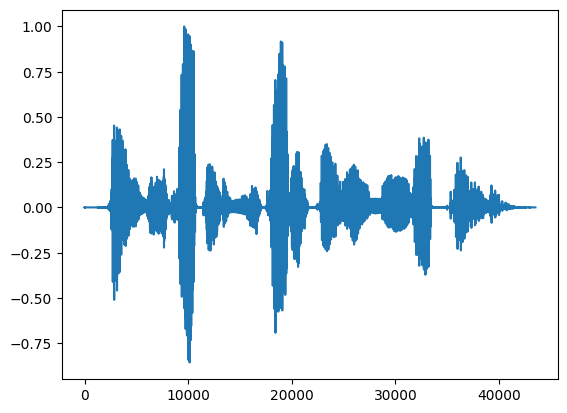

In [3]:
data=data/max(abs(data))
plt.plot(data)

In [4]:
frame_length_ms = 25 # in miliseconds
hop_length_ms = 12.5 # in miliseconds

frame_length = int(np.around((frame_length_ms/1000)*Fs))# 25ms in samples
hop_size = int(np.around((hop_length_ms/1000)*Fs))# 12.5 ms (25/2 ms) in samples (50% overlap)
window_types = ('rect','hann','cosine','hamming')# window types

# Windowing of speech

In [8]:
# Split the data sequence into windows.

def windowing_function(data, frame_length, hop_size, windowing_function):
    data = np.array(data)
    number_of_frames = 1 + int(np.floor((len(data)-frame_length)/hop_size))
    frame_matrix = np.zeros((frame_length,number_of_frames))

    if windowing_function == 'rect':
        window = np.ones((frame_length))
    elif windowing_function == 'hann':
        window = np.hanning(frame_length)
    elif windowing_function == 'cosine':
        window = np.sqrt(np.hanning(frame_length))
    elif windowing_function == 'hamming':
        window = np.hamming(frame_length)
    else:
        os.error('Windowing function not supported')

        
    for i in range(number_of_frames):
        start = i*hop_size
        stop = np.minimum(start+frame_length,len(data))

        frame = np.zeros(frame_length)

        frame[0:stop-start] = data[start:stop]
        frame_matrix[:,i] = np.multiply(window,frame)
    return frame_matrix

In [9]:
frame_matrix =windowing_function(data, frame_length, hop_size, window_types[3])# Windowing

In [10]:
frame_matrix.shape

(400, 216)

In [ ]:
# Functions to complete in the exercise

# Zero-crossing rate (ZCR)

The zero-crossing rate is defined as the number of instances that the sign of the product of two consequtive samples within a frame is negative. i.e.,
\begin{equation}
 zcr = \sum_{i=1}^{N} [sign(s[n]s[n-1]) < 0]
\end{equation}

In [11]:
def zcr(frame):
    # Count the number of times that a signal crosses the zero-line
    #Inputs: frame: the input signal frame
    #Outputs: zcr: The zero-crossing rate of a zero-mean frame.
    # (I.e. Remember to remove the mean from the frame!!)

    zcr = 0
    frame = frame - np.mean(frame)
    for i in range(1,len(frame)):
        if (frame[i]*frame[i-1]) < 0:
            zcr = zcr+1

    return zcr

In [12]:
# Implement zero-crossing rate (ZCR) computation
zcr_vec = np.zeros((1,len(frame_matrix[0])))
for iFrame in range(len(frame_matrix[0])):
    zcr_vec[0,iFrame] = zcr(frame_matrix[:,iFrame])

# Energy

The average energy $e$ of a signal $s[n]$ of length $N$ is defined as.
\begin{equation}
	e = \frac{1}{N}\sqrt{\sum_{i=1}^{N} s[i]^2}
\end{equation}

In many cases, it is desirable to remove the DC component (mean value) of the frame before computing the energy.


In [13]:
def energy(frame):
    #Compute the energy of a given frame (with mean removed)
    #Inputs: frame: the input signal frame
    #Outputs: energy: Frame energy

    frame = frame-np.mean(frame)
    energy = np.sqrt(np.sum(np.power(frame,2)))

    return energy

In [14]:
# Implement energy computation
energy_vec = np.zeros((1,len(frame_matrix[0])))
for iFrame in range(len(frame_matrix[0])):
    energy_vec[0,iFrame] = energy(frame_matrix[:,iFrame])

# Peak values of autocorrelation and cepstrum 

This is based on exercise 2: i.e., deriving peak values of autocorrelation and cepstrum.

In [15]:
def F0_autocorr(frame,fs,f0_min,f0_max,vuv_threshold):

    frame = np.array(frame)
    frame = frame-np.mean(frame)
    max_lag = int(np.ceil(fs/f0_min))
    min_lag = int(np.floor(fs/f0_max))
    r = np.correlate(frame,frame, mode='full')
    r = r/np.amax(np.absolute(r))
    r = r[(len(frame)-1):]
    r = r[min_lag:max_lag]
    ac_peak_val = np.amax(r)
    ind = np.argmax(r)

    if ac_peak_val > vuv_threshold:
        f0 = fs/(min_lag+ind)
    else:
        f0 = 0

    return f0,ac_peak_val

In [16]:
def F0_cepstrum(frame,fs,f0_min,f0_max,vuv_threshold):

    frame = np.array(frame)
    max_lag = int(np.ceil(fs/f0_min))
    min_lag = int(np.floor(fs/f0_max))
    eps = 0.00001
    c = np.real(np.fft.ifft(np.log10(np.absolute(np.power(np.fft.fft(frame),2) + eps))))
    c = c[min_lag:max_lag]
    cepstral_peak_val = np.amax(np.absolute(c))
    ind = np.argmax(c)
    if cepstral_peak_val > vuv_threshold:
        f0 = fs/(min_lag+ind)
    else:
        f0 = 0

    return f0,cepstral_peak_val

In [17]:
# Obtain peak values of autocorrelation and cepstrum
f0_max = 200
f0_min = 50

F0_ac = np.zeros((1,len(frame_matrix[0])))
F0_cep = np.zeros((1,len(frame_matrix[0])))

ac_peak_vec = np.zeros((1,len(frame_matrix[0])))
ceps_peak_vec = np.zeros((1,len(frame_matrix[0])))

for iFrame in range(len(frame_matrix[0])):
    F0_ac[0,iFrame],ac_peak_vec[0,iFrame] = F0_autocorr(frame_matrix[:,iFrame],Fs,f0_min,f0_max,0)
    F0_cep[0,iFrame],ceps_peak_vec[0,iFrame] = F0_cepstrum(frame_matrix[:,iFrame],Fs,f0_min,f0_max,0)

# Concatenate features

In [18]:
# Concatenate all six feature vectors you have already calculated (ZCR, Energy,F0_ac, F0_cep, ac_peak_vec and ceps_peak_vec)
# Rows represent features, and columns represent frame number.
vad_input = np.concatenate((zcr_vec,energy_vec,ac_peak_vec,ceps_peak_vec,F0_ac,F0_cep),axis=0)

In [19]:
vad_input.shape

(6, 216)

# Delta and delta-deltas to input features

The delta- and delta-deltas features of a signal are defined as their first and second time derivatives. The accurate estimation of time derivatives for discrete signals can be tricky, but for most purposes first-order central finite difference coefficients are sufficient:
\begin{equation}
	f^\prime(x_0) \approx -\frac{1}{2}f(x_{-1}) + \frac{1}{2}f(x_{+1})
\label{eq:d}
\end{equation}
and 
\begin{equation}
	f^{\prime\prime}(x_0) \approx f(x_{-1}) -2f(x_{0})   +f(x_{+1}) \label{eq:dd}
\end{equation}

In practice, the computation of delta- and delta-deltas parameters is most easily obtained with the 'lfilter' function (scipy.signal) by setting the FIR filter coefficients corresponding to those of above equations.

In [20]:
def add_deltas_deltadeltas(vad_input):
    #Add delta and delta-delta features to features of input matrix. Rows represent features, and columns represent frames.
    #Inputs: vad_input: m x n matrix with m features and n frames
    #Outputs: output: 3*m x n matrix whose rows contain original features, delta and delta-delta features

    #Delta and Delta-delta filters:
    #https://en.wikipedia.org/wiki/Finite_difference_coefficient
    filt_dx = [0.5, 0, -0.5]
    filt_ddx = [1, -2, 1]
    output_size = (3*len(vad_input), len(vad_input[0]))
    output = np.zeros(output_size)

    for i in range(len(vad_input)):
        temp = np.zeros((3,len(vad_input[0])))
        temp[0,:] = vad_input[i,:] #Select a feature row
        temp[1,:] = sig.lfilter(filt_dx,1,vad_input[i,:])#Compute deltas
        temp[2,:] = sig.lfilter(filt_ddx,1,vad_input[i,:])#Compute delta-deltas
        output[(i*3):((i+1)*3),:] = temp #add to output

    return output

In [21]:
#Add deltas and delta-deltas to input
vad_input = add_deltas_deltadeltas(vad_input)

In [22]:
vad_input.shape

(18, 216)

# Normalize each input parameter to zero-mean and unit variance vectors

In [23]:
def normalize(M):
    # Normalize (zero-mean and unit variance) the values of input matrix M for each row.

    output = np.zeros(M.shape)

    for i in range(len(M)):
        tmp = M[i,:]
        tmp = tmp - np.mean(tmp)
        tmp = tmp/np.linalg.norm(tmp,ord=2)
        output[i,:] = tmp
    
    return output

In [24]:
vad_input = normalize(vad_input)

# Read ground truth

In [25]:
def read_ground_truth():
    #Target files must be in the same directory
    with open('ground_truth','r') as f:
        data = f.read() 
    targets = np.array([int(i) for i in data.split()])
    targets = targets.reshape((1,len(targets)))
    return targets

# Linear classifiers

We will train two different classifiers with the toy-sized data set of a single utterance for out experiments. A linear classifier learns a set of weights $w$ that form a linear combination mapping of an input vector $x_k$ into a target output value $y_k$:
\begin{equation}
 y_k = x_k^Tw
\end{equation}

Classification is done by "thresholding" $y$  according to the zero-level. A simple linear classifier is trained with training data with inputs on matrix $X = [x_0, x_1, \ldots]$ corresponding to a labeled target vector $y = [y_0, y_1, \ldots]$ with the "pseudo inverse" of $X$:
\begin{equation}
	w = (XX^T)^{-1}Xy^T
\end{equation}

# Perceptron

Perceptron is another formulation of a linear classifier. Perceptron also maps the linear combination of the input vector into the target class of a binary value:
\begin{align}
	f(x) &= 1, \qquad \text{if } x^Tw > 0 \\
	     &= 0, \qquad \text{otherwise}
\end{align}
The difference between the least-squares linear classifier and the perceptorn is the learning algorithm. Within the pseudo-inverse classifier, the analytic least-squares solution can be derived by minimizing the prediction error before thresholding; within the perceptron model the weights are adjusted iteratively based on the classification error  obtained after thresholding.

In [26]:
def perceptron_training(vad_input, outputs):

    MAX_ITER = 100000
    w = np.zeros((1,len(vad_input)))
    y = np.zeros((1,len(outputs)))

    #Training
    for iter in range(MAX_ITER):
        #Compute weight gradient
        dw = np.matmul((outputs - y), vad_input.T) / len(vad_input[0])

        #update weights
        w = w + dw

        #Apply non-linearity
        y = (np.matmul(w, vad_input) > 0)

    print('Perceptron training complete after '+str(iter)+' iterations.')

    return w

## Train a perceptron model with the computed input parameters for VAD.

In [27]:
#Load target output
vad_target = read_ground_truth()

#Add bias vector to input parameters
vad_input = np.concatenate((np.ones((1,len(vad_input[0]))),vad_input),axis=0)

#Train a perceptron model (linear classifier with output non-linearity)
w_perceptron = perceptron_training(vad_input,vad_target)

#Train a linear classifier
w_linear = np.matmul((vad_target - 0.5),np.linalg.pinv(vad_input))

Perceptron training complete after 99999 iterations.


In [31]:
#Use the obtained models to make the predictions for perceptron

thresh_perceptron = 0
vad_perceptron = (np.matmul(w_perceptron,vad_input) > thresh_perceptron).astype(np.int32)
error_perceptron = np.mean(np.absolute(vad_perceptron - vad_target))
print('Error of perceptron: '+str(error_perceptron))

Error of perceptron: 0.0


In [32]:
# Make the predictions for linear classifier

thresh_linear = 0.0
vad_linear = (np.matmul(w_linear,vad_input) > thresh_linear).astype(np.int32)
error_linear = np.mean(np.absolute(vad_linear - vad_target))
print('Error of classifier: '+str(error_linear))

Error of classifier: 0.06481481481481481


# Visualizations ()

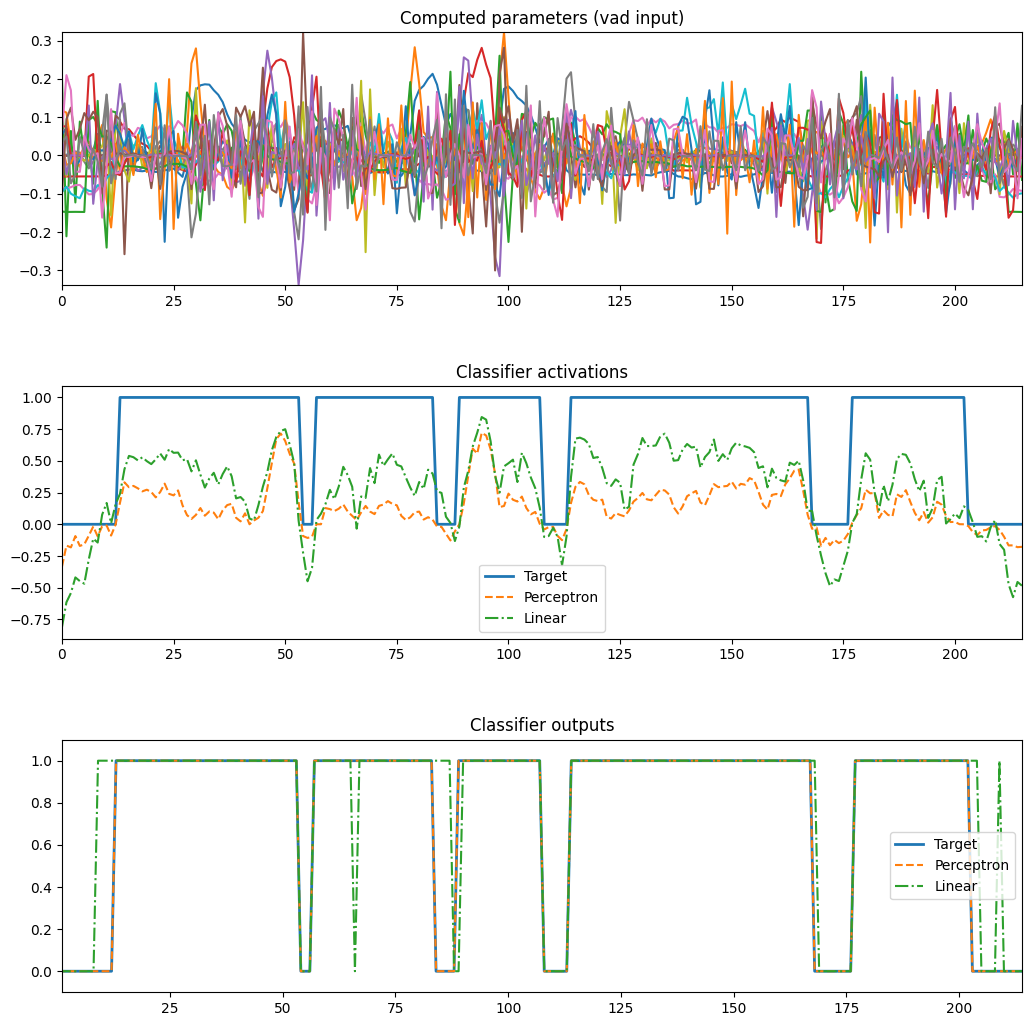

In [40]:
# visualize your results

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
fig.tight_layout()

# Plot the input vectors
plt.subplot(3,1,1)
plt.plot(vad_input[1:,:].T)
plt.autoscale(enable=True, axis='both', tight=True)
plt.title('Computed parameters (vad input)')

# Plot the classifier activation values (y = X.transpose * W) for each frame (without classification)

plt.subplot(3,1,2)
plt.plot(vad_target.T,linewidth=2)
plt.plot(np.matmul(w_perceptron,vad_input).T,'--')
plt.plot(np.matmul(w_linear,vad_input).T,'-.')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(('Target','Perceptron','Linear'))
plt.title('Classifier activations')

# Plot the ground truth (target) vector and obtained classification results for both classifiers
plt.subplot(3,1,3)
plt.plot(vad_target.T,linewidth=2)
plt.plot(vad_perceptron.T,'--')
plt.plot(vad_linear.T,'-.')
plt.axis([1,214,-0.1,1.1])
plt.legend(('Target','Perceptron','Linear'))
plt.title('Classifier outputs')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)

# Experiment with different input parameters.
### a) What is the single best feature (out of four) for VAD classification in the test utterance?
### b) What is the worst performing single parameter?
### c) What other features do you think could be useful in VAD?
### d) What do you think is the challenging aspect in VAD task?

# Write your observations of the exercise here












# Test your VAD detector on your own voice (Optional)

Record your own speech file, then create a ground truth and then run this notebook for your speech file. Upload the speech, ground truth files and write your observations below.

## Expected Result (example)
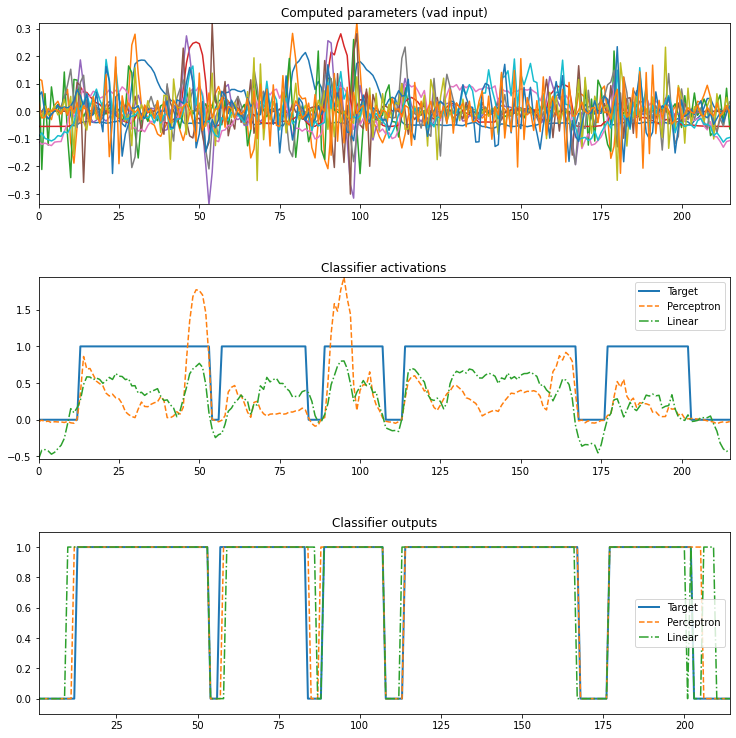